In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 
from rdkit import Chem
from rdkit.Chem import Draw
import os
import sys
from rdkit.Chem.Draw import IPythonConsole
from collections import Counter
import torch
import json

In [2]:

def get_reaction_components(reaction_smiles):
    return reaction_smiles.split('>>')

def num_molecules(smiles):
    return len(smiles.split('.'))

def num_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol else 0

def unique_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return set()
    return list(set(atom.GetSymbol() for atom in mol.GetAtoms()))

def unique_atoms_num(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return set()
    return list(set(atom.GetAtomicNum() for atom in mol.GetAtoms()))

def num_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumBonds() if mol else 0


def bond_types(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return []
    bond_types = [bond.GetBondType() for bond in mol.GetBonds()]
    return bond_types

def num_of_heavy_molecules(smiles):
    smils_list = smiles.split('.')
    heavy_smiles = []
    for s in smils_list:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            return False  # Invalid SMILES
        num_atoms = mol.GetNumAtoms()
        if num_atoms > 1:  # More than one atom, hence not a single atom or ion
            h_s = Chem.MolToSmiles(mol)
            heavy_smiles.append(h_s)
    return len(heavy_smiles)

def plot_reaction_class_distribution(reaction_class_distribution):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=reaction_class_distribution.index, y=reaction_class_distribution.values, palette='viridis')
    plt.xlabel('Reaction Class')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reaction Classes')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    path = 'plots'
    os.makedirs(path, exist_ok=True)
    plt.savefig(f'{path}/reaction_class_distribution.png')
    plt.show()

def get_reaction_mols(reaction_smiles):
    """
    Returns reactant and product molecules from a reaction SMILES string.
    Args:
        reaction_smiles (str): Reaction SMILES string.
    Returns:
        tuple: A tuple containing reactant and product RDKit molecule objects.
    """
    reactantes_smiles, products_smiles = reaction_smiles.split('>>')
    reactantes_mol = Chem.MolFromSmiles(reactantes_smiles)
    products_mol = Chem.MolFromSmiles(products_smiles)
    return reactantes_mol, products_mol 

**Dataset** from https://github.com/vsomnath/graphretro

In [3]:
df_train = pd.read_csv('../datasets/raw/canonicalized_train.csv', names=['id', 'class', 'reaction'], skiprows=1)
df_test = pd.read_csv('../datasets/raw/canonicalized_test.csv', names=['id', 'class', 'reaction'], skiprows=1)
df_vaid = pd.read_csv('../datasets/raw/canonicalized_eval.csv', names=['id', 'class', 'reaction'], skiprows=1)
print(len(df_train), len(df_test), len(df_vaid), sum([len(df_train), len(df_test), len(df_vaid)]))
df = pd.concat([df_train, df_test, df_vaid])
print(len(df))
print(df.head(10))

40008 5007 5001 50016
50016
                id  class                                           reaction
0       US05849732      6  [CH3:1][O:2][C:3](=[O:4])[C@H:5]([CH2:6][CH2:7...
1  US20120114765A1      2  [NH2:3][c:4]1[cH:5][cH:6][cH:7][c:8]2[cH:9][n:...
2     US08003648B2      1  [CH3:1][CH2:2][NH:3][CH2:4][CH3:5].[CH:6]([c:7...
3     US09045475B2      1  [C:31]([CH2:32][F:33])([CH2:34][F:35])=[O:65]....
4     US08188098B2      2  [C:22](=[O:23])([O:24][CH:25]1[CH2:26][CH2:27]...
5  US20140275084A1      3  [CH3:1][n:2]1[cH:3][n:4][c:5](-[c:6]2[cH:7][c:...
6  US20110224204A1      3  [N:1]#[C:2][c:3]1[cH:4][cH:5][c:6]([O:7][CH:8]...
7  US20130005716A1      7  [CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([C:7](=[O:...
8  US20130172384A1      2  [C:10](=[O:11])([c:12]1[cH:13][cH:14][c:15]([B...
9  US20050277619A1      1  [CH2:8]([c:9]1[n:10][c:11]2[c:12]([NH2:13])[n:...


In [4]:
df[['reactants', 'products']] = df['reaction'].apply(lambda x: pd.Series(get_reaction_components(x)))

df['num_molecules_reactants'] = df['reactants'].apply(num_molecules)
df['num_molecules_products'] = df['products'].apply(num_molecules)

df['num_atoms_reactants'] = df['reactants'].apply(num_atoms)
df['num_atoms_products'] = df['products'].apply(num_atoms)

df['unique_atoms_reactants'] = df['reactants'].apply(unique_atoms)
df['unique_atoms_products'] = df['products'].apply(unique_atoms)

df['unique_atoms_reactants_num'] = df['reactants'].apply(unique_atoms_num)
df['unique_atoms_products_num'] = df['products'].apply(unique_atoms_num)

df['num_bonds_reactants'] = df['reactants'].apply(num_bonds)
df['num_bonds_products'] = df['products'].apply(num_bonds)

df['bond_types_reactants'] = df['reactants'].apply(bond_types)
df['bond_types_products'] = df['products'].apply(bond_types)

df['heavy_reactants'] = df['reactants'].apply(num_of_heavy_molecules)

df['unique_atoms_reactants_num'] = df['reactants'].apply(unique_atoms_num)
df['unique_atoms_products_num'] = df['products'].apply(unique_atoms_num)


Reaction class distribution:
1     15151
2     11896
6      8237
3      5662
7      4614
9      1834
4       909
8       811
5       672
10      230
Name: class, dtype: int64


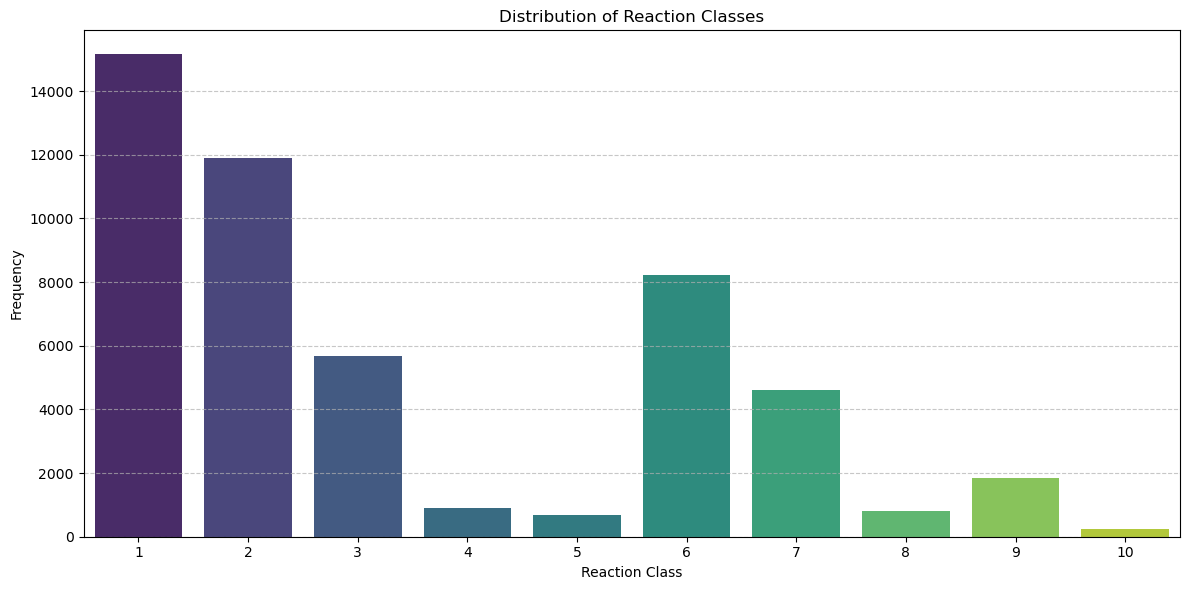

In [5]:
reaction_class_distribution = df["class"].value_counts()
print(f'Reaction class distribution:\n{reaction_class_distribution}')

plot_reaction_class_distribution(reaction_class_distribution)

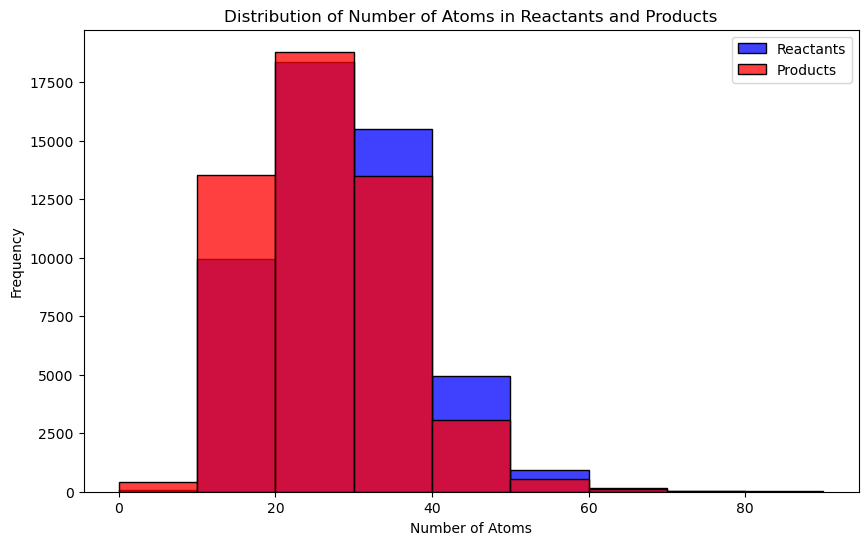

Average number of atoms in reactants: 28.292206493921945
Average number of atoms in products: 25.962412028150993
Minimum number of atoms in reactants: 4 and maximum number of atoms in reactants: 97
Minimum number of atoms in products: 1 and maximum number of atoms in products: 97
Mode of number of atoms in reactants: 27 and mode of number of atoms in products: 29
Median of number of atoms in reactants: 28.0 and median of number of atoms in products: 25.0


In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['num_atoms_reactants'],bins=range(0, df['num_atoms_reactants'].max() + 2, 10), color='blue', label='Reactants')
sns.histplot(df['num_atoms_products'],bins=range(0, df['num_atoms_reactants'].max() + 2, 10), color='red', label='Products')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Atoms in Reactants and Products')
plt.legend()
plt.show()

print(f'Average number of atoms in reactants: {df["num_atoms_reactants"].mean()}')
print(f'Average number of atoms in products: {df["num_atoms_products"].mean()}')
print(f'Minimum number of atoms in reactants: {df["num_atoms_reactants"].min()} and maximum number of atoms in reactants: {df["num_atoms_reactants"].max()}')
print(f'Minimum number of atoms in products: {df["num_atoms_products"].min()} and maximum number of atoms in products: {df["num_atoms_products"].max()}')
print(f'Mode of number of atoms in reactants: {df["num_atoms_reactants"].mode()[0]} and mode of number of atoms in products: {df["num_atoms_products"].mode()[0]}')
print(f'Median of number of atoms in reactants: {df["num_atoms_reactants"].median()} and median of number of atoms in products: {df["num_atoms_products"].median()}')


In [7]:

def bin_atoms_counts(data, column_name, bin_width):
    bins = range(0, max(data[column_name]) + bin_width, bin_width)
    labels = [f'{i}-{i + bin_width}' for i in bins[:-1]]
    data['bin'] = pd.cut(data[column_name], bins=bins, labels=labels, include_lowest=True)
    return data.groupby('bin').size()


def plot_distribution_of_reactions(type,df):
    if type == 'atoms':
        bin_width = 10
        counts_reactants = bin_atoms_counts(df, 'num_atoms_reactants', bin_width)
        counts_products = bin_atoms_counts(df, 'num_atoms_products', bin_width)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts_reactants.index, y=counts_reactants.values, color='blue', alpha=0.5, label='Reactants')
        sns.barplot(x=counts_products.index, y=counts_products.values, color='red', alpha=0.5, label='Products')
        plt.xlabel('Number of Atoms')
        plt.ylabel('Number of Reactions')
        plt.title('Distribution of Reactions by Number of Atoms in Reactants and Products')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    elif type == 'bonds':
        bin_width = 10
        counts_reactants = bin_atoms_counts(df, 'num_bonds_reactants', bin_width)
        counts_products = bin_atoms_counts(df, 'num_bonds_products', bin_width)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts_reactants.index, y=counts_reactants.values, color='blue', alpha=0.5, label='Reactants')
        sns.barplot(x=counts_products.index, y=counts_products.values, color='red', alpha=0.5, label='Products')
        plt.xlabel('Number of Bonds')
        plt.ylabel('Number of Reactions')
        plt.title('Distribution of Reactions by Number of Bonds in Reactants and Products')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

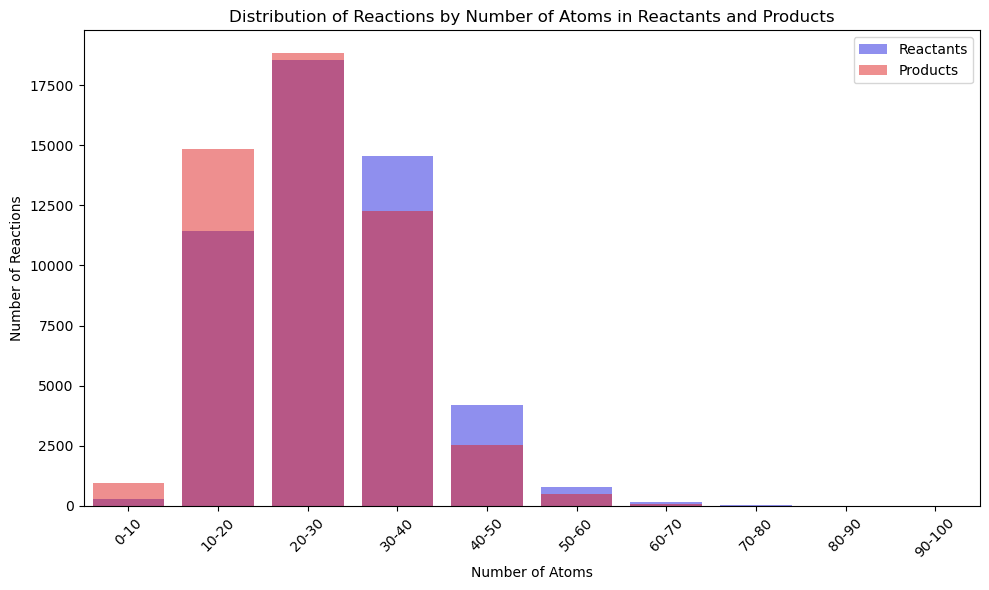

total number of atoms in reactants: 1415063
total number of atoms in products: 1298536


In [8]:
plot_distribution_of_reactions('atoms',df)
print('total number of atoms in reactants:', df['num_atoms_reactants'].sum() )
print('total number of atoms in products:', df['num_atoms_products'].sum() )

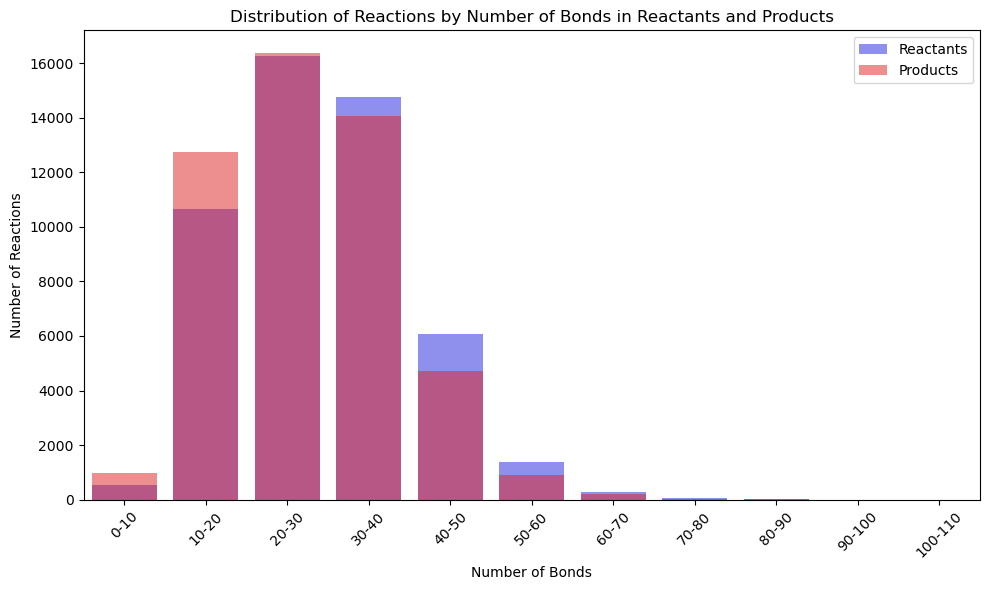

total number of bonds in reactants: 1483754
total number of bonds in products: 1400108


In [9]:
plot_distribution_of_reactions('bonds',df)
print('total number of bonds in reactants:', df['num_bonds_reactants'].sum() )
print('total number of bonds in products:', df['num_bonds_products'].sum() )

In [10]:
print('ration of number of atoms in reactants to number of atoms in products:', df['num_atoms_reactants'].sum() / df['num_atoms_products'].sum() )
print('ration of number of bonds in reactants to number of bonds in products:', df['num_bonds_reactants'].sum() / df['num_bonds_products'].sum() )
print('ration of number of atoms to number of bonds in reactants:', df['num_atoms_reactants'].sum() / df['num_bonds_reactants'].sum() )
print('ration of number of atoms to number of bonds in products:', df['num_atoms_products'].sum() / df['num_bonds_products'].sum() )

ration of number of atoms in reactants to number of atoms in products: 1.0897372117523119
ration of number of bonds in reactants to number of bonds in products: 1.0597425341473659
ration of number of atoms to number of bonds in reactants: 0.9537045898444082
ration of number of atoms to number of bonds in products: 0.9274541678213395


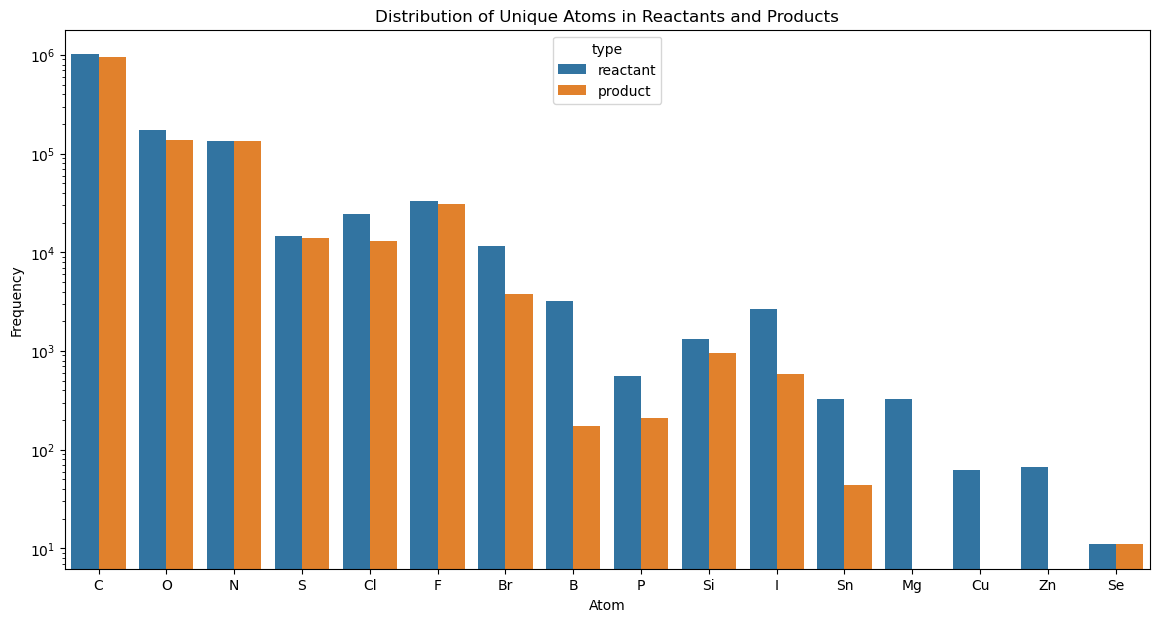

In [11]:
def extract_atoms(smiles):
    atom_list = []
    smils_list = smiles.split('.')
    for s in smils_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            for atom in mol.GetAtoms():
                atom_list.append(atom.GetSymbol())
    return atom_list

df['atoms_reactants'] = df['reactants'].apply(extract_atoms)
df['atoms_products'] = df['products'].apply(extract_atoms)

reactant_atoms_counter = Counter([atom for sublist in df['atoms_reactants'] for atom in sublist])
product_atoms_counter = Counter([atom for sublist in df['atoms_products'] for atom in sublist])

reactant_atoms_df = pd.DataFrame.from_dict(reactant_atoms_counter, orient='index', columns=['frequency']).reset_index()
reactant_atoms_df.columns = ['atom', 'frequency']
reactant_atoms_df['type'] = 'reactant'

product_atoms_df = pd.DataFrame.from_dict(product_atoms_counter, orient='index', columns=['frequency']).reset_index()
product_atoms_df.columns = ['atom', 'frequency']
product_atoms_df['type'] = 'product'

atoms_df = pd.concat([reactant_atoms_df, product_atoms_df])

plt.figure(figsize=(14, 7))
sns.barplot(data=atoms_df, x='atom', y='frequency', hue='type')
plt.xlabel('Atom')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Unique Atoms in Reactants and Products')
plt.show()


In [12]:
unique_atoms_reactants = set().union(*df['unique_atoms_reactants'])
unique_atoms_products = set().union(*df['unique_atoms_products'])

unique_atoms_in_dataset = unique_atoms_reactants.union(unique_atoms_products)

print(f'Unique atoms in reactants: {unique_atoms_reactants}','len(unique_atoms_reactants)' ,len(unique_atoms_reactants))
print(f'Unique atoms in products: {unique_atoms_products}', 'len(unique_atoms_products)',len(unique_atoms_products))
print(f'Unique atoms in dataset: {unique_atoms_in_dataset}', 'len(unique_atoms_in_dataset)',len(unique_atoms_in_dataset))

Unique atoms in reactants: {'Se', 'Mg', 'Cl', 'Cu', 'Br', 'Si', 'Sn', 'O', 'Zn', 'I', 'P', 'C', 'S', 'F', 'N', 'B'} len(unique_atoms_reactants) 16
Unique atoms in products: {'Se', 'B', 'Cl', 'Br', 'Si', 'Sn', 'O', 'I', 'C', 'S', 'F', 'N', 'P'} len(unique_atoms_products) 13
Unique atoms in dataset: {'Se', 'Cl', 'Zn', 'O', 'P', 'C', 'N', 'B', 'Mg', 'Cu', 'Br', 'Si', 'I', 'F', 'S', 'Sn'} len(unique_atoms_in_dataset) 16


In [13]:
np.save('atom_list', list(unique_atoms_in_dataset))

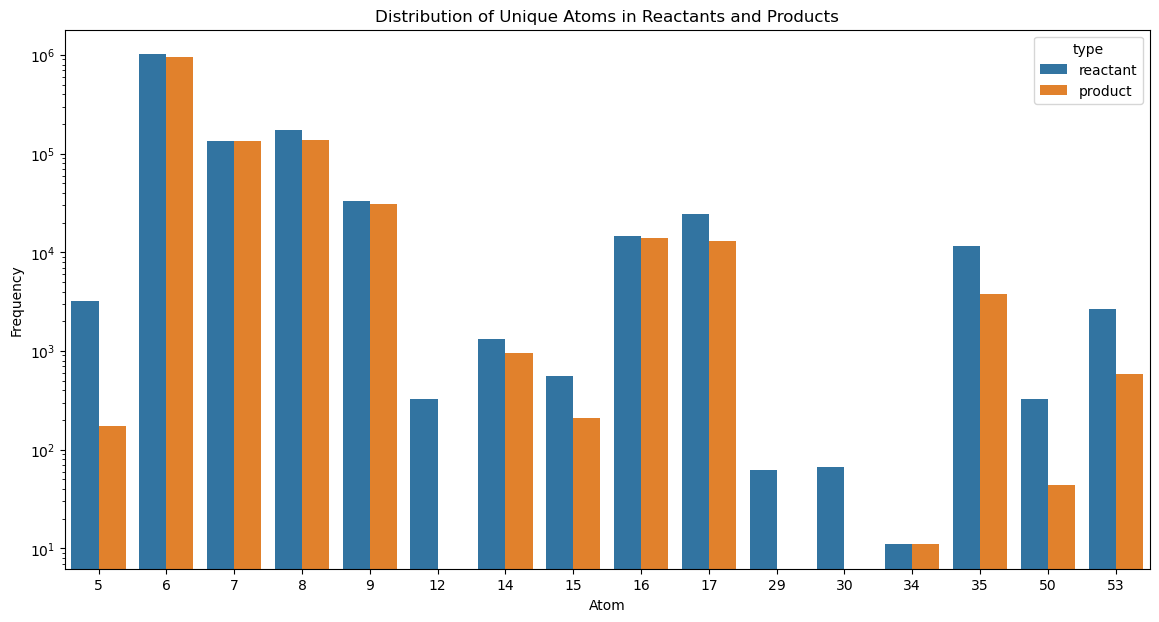

In [14]:
def extract_atoms(smiles):
    atom_list = []
    smils_list = smiles.split('.')
    for s in smils_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            for atom in mol.GetAtoms():
                atom_list.append(atom.GetAtomicNum())
    return atom_list

df['atoms_reactants'] = df['reactants'].apply(extract_atoms)
df['atoms_products'] = df['products'].apply(extract_atoms)

reactant_atoms_counter = Counter([atom for sublist in df['atoms_reactants'] for atom in sublist])
product_atoms_counter = Counter([atom for sublist in df['atoms_products'] for atom in sublist])

reactant_atoms_df = pd.DataFrame.from_dict(reactant_atoms_counter, orient='index', columns=['frequency']).reset_index()
reactant_atoms_df.columns = ['atom', 'frequency']
reactant_atoms_df['type'] = 'reactant'

product_atoms_df = pd.DataFrame.from_dict(product_atoms_counter, orient='index', columns=['frequency']).reset_index()
product_atoms_df.columns = ['atom', 'frequency']
product_atoms_df['type'] = 'product'

atoms_df = pd.concat([reactant_atoms_df, product_atoms_df])

plt.figure(figsize=(14, 7))
sns.barplot(data=atoms_df, x='atom', y='frequency', hue='type')
plt.xlabel('Atom')
plt.yscale('log')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Atoms in Reactants and Products')
plt.show()


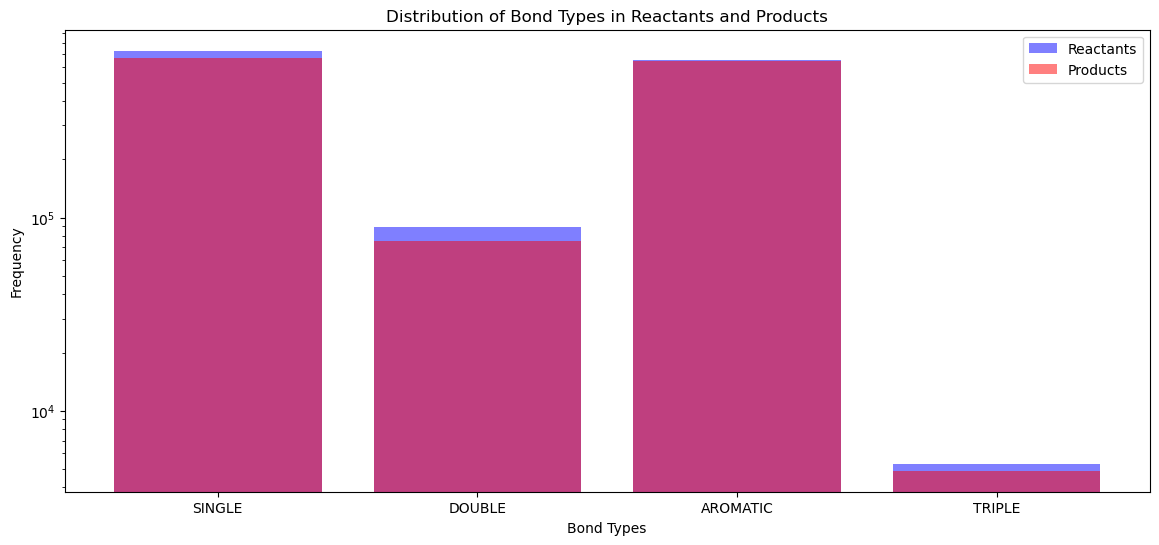

In [15]:

def count_bond_types(bond_types):
    counter = Counter(bond_types)
    bond_type_dict = {str(k): v for k, v in counter.items()}
    return bond_type_dict

bond_types_reactants = df['bond_types_reactants'].apply(count_bond_types)
bond_types_products = df['bond_types_products'].apply(count_bond_types)

all_bond_types_reactants = Counter()
for bond_dict in bond_types_reactants:
    all_bond_types_reactants.update(bond_dict)

all_bond_types_products = Counter()
for bond_dict in bond_types_products:
    all_bond_types_products.update(bond_dict)

plt.figure(figsize=(14, 6))
plt.bar(all_bond_types_reactants.keys(), all_bond_types_reactants.values(), color='blue', alpha=0.5, label='Reactants')
plt.bar(all_bond_types_products.keys(), all_bond_types_products.values(), color='red', alpha=0.5, label='Products')
plt.xlabel('Bond Types')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Bond Types in Reactants and Products')
plt.legend()
plt.show()



In [16]:
n_p_greater_index = []
diff_list = []
cnt_n_r_greater = 0
for idx in range(len(df)):
    reaction_smiles =df.reaction.iloc[idx]

    reactantes_mol, product_mol = get_reaction_mols(reaction_smiles)
    n_r = reactantes_mol.GetNumAtoms()
    n_p = product_mol.GetNumAtoms()
    if n_p > n_r:
        n_p_greater_index.append(idx)
        diff_list.append(n_p - n_r)
    else:
        cnt_n_r_greater += 1
print(len(n_p_greater_index), cnt_n_r_greater)
print(diff_list)
print(n_p_greater_index)


0 50016
[]
[]


In [17]:
small_test_index = [] # for visualization
for idx in range(len(df_test)):
    reaction_smiles =df.reaction.iloc[idx]

    reactantes_mol, product_mol = get_reaction_mols(reaction_smiles)
    n_r = reactantes_mol.GetNumAtoms()
    n_p = product_mol.GetNumAtoms()
    if n_p < 15:
        small_test_index.append(idx)
    
print(small_test_index)


[18, 23, 43, 51, 61, 66, 80, 83, 86, 99, 130, 141, 157, 162, 173, 188, 190, 210, 212, 218, 219, 221, 246, 260, 261, 267, 281, 284, 285, 304, 312, 317, 319, 332, 335, 363, 365, 366, 405, 411, 423, 425, 433, 462, 476, 478, 488, 492, 503, 505, 509, 511, 523, 532, 540, 563, 565, 598, 599, 600, 612, 615, 626, 635, 644, 676, 693, 700, 712, 713, 718, 719, 723, 724, 730, 731, 745, 746, 768, 797, 798, 818, 821, 838, 839, 853, 857, 865, 889, 892, 894, 903, 904, 909, 914, 919, 933, 934, 945, 951, 953, 963, 966, 980, 985, 1000, 1002, 1006, 1012, 1036, 1045, 1058, 1071, 1077, 1089, 1091, 1095, 1105, 1130, 1134, 1165, 1173, 1212, 1213, 1232, 1240, 1257, 1267, 1278, 1302, 1313, 1331, 1350, 1351, 1355, 1356, 1365, 1368, 1381, 1385, 1386, 1387, 1414, 1418, 1423, 1431, 1446, 1455, 1460, 1473, 1475, 1476, 1497, 1507, 1515, 1545, 1549, 1554, 1564, 1565, 1567, 1568, 1569, 1574, 1580, 1590, 1605, 1607, 1626, 1627, 1629, 1642, 1650, 1663, 1664, 1676, 1679, 1699, 1702, 1711, 1725, 1728, 1744, 1757, 1776, 1779

In [18]:
from utils_data import *
total_edits = []
for i, data in df.iterrows():
    reaction = data.reaction
    reactant_mol , product_mol = get_reaction_mols(reaction)
    e, _, _, _ = compute_graph_edit_distance(reactant_mol, product_mol)
    total_edits.append(e)

print(np.mean(total_edits), np.std(total_edits), dict(Counter(total_edits)))

1.1644673704414588 0.6943396530501164 {1: 44932, 2: 3967, 6: 83, 4: 92, 5: 209, 3: 478, 8: 44, 7: 170, 15: 11, 11: 17, 10: 6, 13: 2, 12: 2, 9: 3}


In [19]:
print(dict(Counter(total_edits)))
print(len(total_edits))
print(len([e for e in total_edits if e == 0])/len(total_edits))
print(len([e for e in total_edits if e == 1])/len(total_edits))
print(len([e for e in total_edits if e == 2])/len(total_edits))
print(len([e for e in total_edits if e == 3])/len(total_edits)) 

{1: 44932, 2: 3967, 6: 83, 4: 92, 5: 209, 3: 478, 8: 44, 7: 170, 15: 11, 11: 17, 10: 6, 13: 2, 12: 2, 9: 3}
50016
0.0
0.8983525271912988
0.07931461932181702
0.009556941778630838


Counter({1: 44932, 2: 3967, 3: 478, 5: 209, 7: 170, 4: 92, 6: 83, 8: 44, 11: 17, 15: 11, 10: 6, 9: 3, 13: 2, 12: 2})


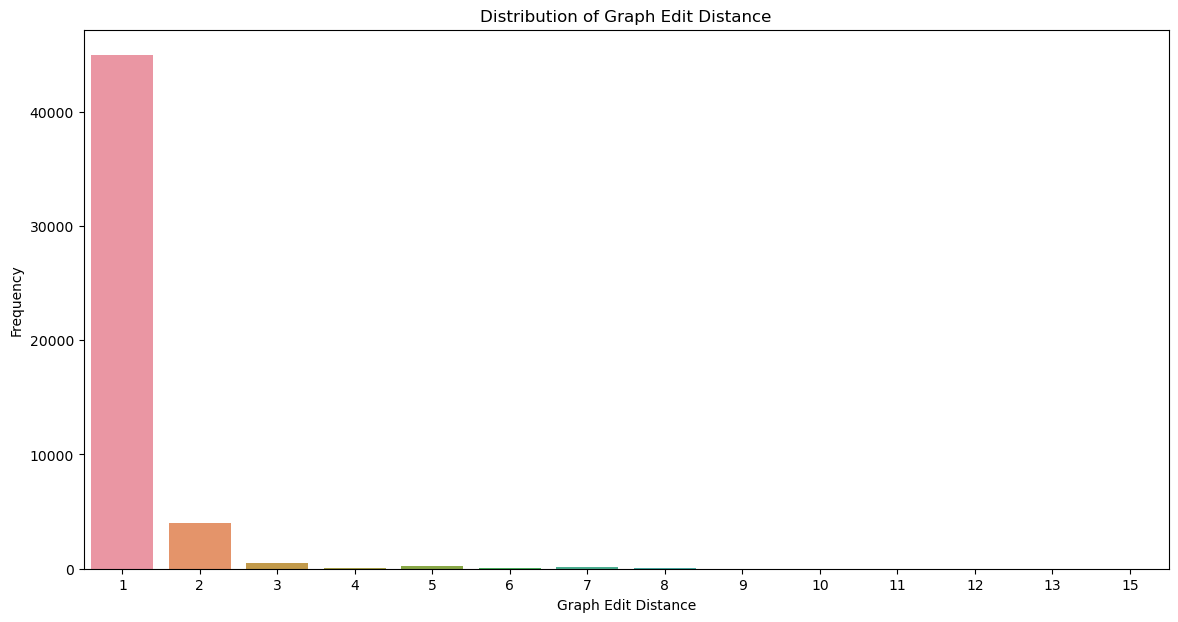

In [20]:
edit_counter = Counter(total_edits)
print(edit_counter)
edit_df = pd.DataFrame.from_dict(edit_counter, orient='index', columns=['frequency']).reset_index()
edit_df.columns = ['edits', 'frequency']

plt.figure(figsize=(14, 7))
sns.barplot(data=edit_df, x='edits', y='frequency')
plt.xlabel('Graph Edit Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Graph Edit Distance')
plt.show()

In [21]:
# processed data
dataset_path = '../datasets/processed/'

if os.path.exists(os.path.join(dataset_path, 'whole_data.pt')):
    whole_data = torch.load(os.path.join(dataset_path, 'whole_data.pt'))    
else:
    train_set = torch.load(os.path.join(dataset_path, 'train.pt'))
    validation_set = torch.load(os.path.join(dataset_path, 'valid.pt'))
    test_set = torch.load(os.path.join(dataset_path, 'test.pt'))
    whole_data = train_set + validation_set + test_set
    torch.save(whole_data, os.path.join(dataset_path, 'whole_data.pt'))
print(len(whole_data))


50016


In [22]:
def count_bond_changes(reaction_data):
    bond_ordreing = 0 # Count for bonds ordering (1)
    bond_breaking = 0  # Count for bonds breaking (2)

    for data in reaction_data:

        reaction = data.reaction_smiles
        reactant_mol , product_mol = get_reaction_mols(reaction)
        full_reaction_center, bond_changes, hydrogen_changes, charge_changes = get_whole_reaction_center(reactant_mol, product_mol)

        for bond, change in bond_changes.items():
            if change == 1:  # Bond ordering
                bond_ordreing += 1
            elif change == 2:  # Bond breaking
                bond_breaking += 1
    return bond_breaking, bond_ordreing

def get_number_of_bonds(reaction_data):
    total_bonds = 0
    for data in reaction_data:
        all_bonds = data.edge_index_p.shape[1]
        num_bonds = all_bonds // 2 
        total_bonds += num_bonds
    return total_bonds

def get_number_of_atoms(reaction_data):
    total_atoms = 0
    for data in reaction_data:
        all_atoms = data.x_p.shape[0]
        total_atoms += all_atoms
    return total_atoms

def atom_changes_per_product(reaction_data):
    atom_change_per_molecule = []
    for data in reaction_data:
        reaction = data.reaction_smiles
        reactant_mol , product_mol = get_reaction_mols(reaction)
        full_reaction_center, bond_changes, hydrogen_changes, charge_changes = get_whole_reaction_center(reactant_mol, product_mol)
        atom_change_per_molecule.append(len(full_reaction_center))
    return atom_change_per_molecule

def plot_atom_changes_distribution(reaction_data):
    atom_change_per_molecule = atom_changes_per_product(reaction_data)
    atom_change_distribution = Counter(atom_change_per_molecule)   
    sorted_edits = sorted(atom_change_distribution.items())
    atom_centers_num, molecule_counts = zip(*sorted_edits)
    plt.figure(figsize=(8, 5))
    img = plt.bar(atom_centers_num, molecule_counts, color='blue', alpha=0.7)
    plt.xlabel("Number of Atom Changes")
    plt.ylabel("Number of Molecules")
    plt.title("Distribution of Atom Edits per Molecule")
    plt.xticks(atom_centers_num)
    plt.yscale('log')
    path = 'plots'
    os.makedirs(path, exist_ok=True)
    plt.savefig('plots/atom_edit_distribution.png', bbox_inches='tight')
    plt.show()  
   

def bond_changes_per_product(reaction_data):
    bond_change_per_molecule = []
    for data in reaction_data:
        reaction = data.reaction_smiles
        reactant_mol , product_mol = get_reaction_mols(reaction)
        full_reaction_center, bond_changes, hydrogen_changes, charge_changes = get_whole_reaction_center(reactant_mol, product_mol)
        bond_change = 0
        for bond, change in bond_changes.items():
            if change in [1, 2]:  # Bond breaking
                bond_change += 1
        bond_change_per_molecule.append(bond_change)
    return bond_change_per_molecule

def plot_bond_changes_distribution(reaction_data):
    bond_change_per_molecule = bond_changes_per_product(reaction_data)
    edit_distribution = Counter(bond_change_per_molecule)
    sorted_edits = sorted(edit_distribution.items())
    edit_numbers, molecule_counts = zip(*sorted_edits)
    plt.figure(figsize=(8, 5))
    plt.bar(edit_numbers, molecule_counts, color='blue', alpha=0.7)
    plt.xlabel("Number of Bond Edits (Order changing + Breaking)")
    plt.ylabel("Number of Molecules")
    plt.title("Distribution of Bond Edits per Molecule")
    plt.xticks(edit_numbers)
    plt.yscale('log')

    plt.savefig('plots/edit_distribution.png', bbox_inches='tight')  
    plt.show()


def bond_changes_per_product_reaction_type(reaction_data):
    bond_change_per_molecule = []
    for data in reaction_data:
        reaction = data.reaction_smiles
        reaction_type = data.reaction_class
        reactant_mol , product_mol = get_reaction_mols(reaction)
        full_reaction_center, bond_changes, hydrogen_changes, charge_changes = get_whole_reaction_center(reactant_mol, product_mol)
        bond_change = 0
        for bond, change in bond_changes.items():
            if change in [1,2]:  
                bond_change += 1
        bond_change_per_molecule.append((bond_change, reaction_type))
    return bond_change_per_molecule

def plot_bond_changes_vs_reaction_type(reaction_data):
    bond_changes = bond_changes_per_product_reaction_type(reaction_data)
    df = pd.DataFrame(bond_changes, columns=["Bond Changes", "Reaction Type"])
    avg_bond_changes = df.groupby("Reaction Type")["Bond Changes"].mean().reset_index()
    avg_bond_changes = avg_bond_changes.sort_values("Bond Changes", ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_bond_changes, x="Reaction Type", y="Bond Changes",hue="Reaction Type", palette="Blues_r")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Reaction Type")
    plt.ylabel("Average Bond Changes")
    plt.title("Average Bond Edits per Reaction Type")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig('plots/bond_changes_vs_reaction_type.png', bbox_inches='tight')
    plt.show()


Total atoms: 1298536
Total atom changes: 94230
Percentage of atom changes: 7.26%


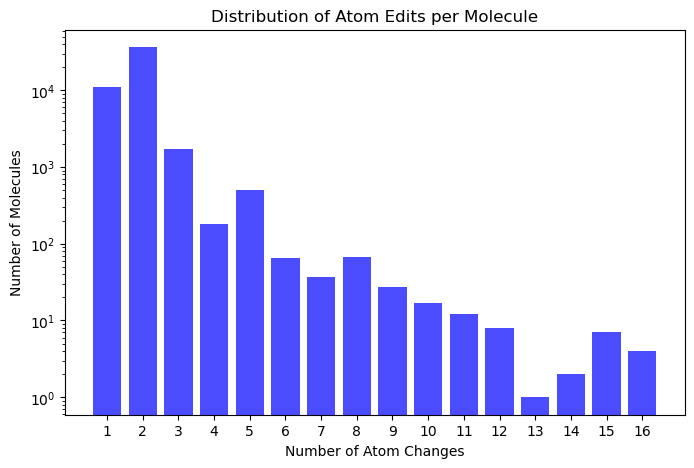

In [23]:
# number of atoms and bonds in products
total_atoms = get_number_of_atoms(whole_data)
print(f"Total atoms: {total_atoms}")
atom_changes = atom_changes_per_product(whole_data)
total_atoms_changes = sum(atom_changes)
print(f"Total atom changes: {total_atoms_changes}")
print(f"Percentage of atom changes: {total_atoms_changes/total_atoms*100:.2f}%")
plot_atom_changes_distribution(whole_data)

Bond breaking: 36960
Bond ordering: 7403
Total bonds: 1400108
Percentage of bond breaking:  2.639796358566625
Percentage of bond ordering:  0.5287449253914698
Percentange of no change bonds:  96.83145871604191
Total bond changes: 44363
Percentage of bond changes: 3.17%


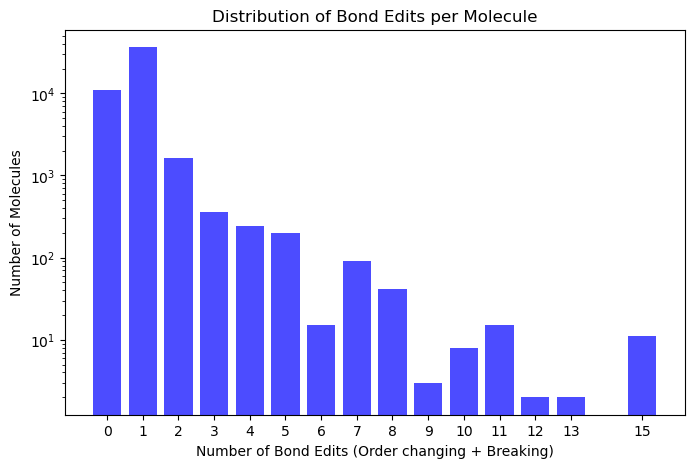

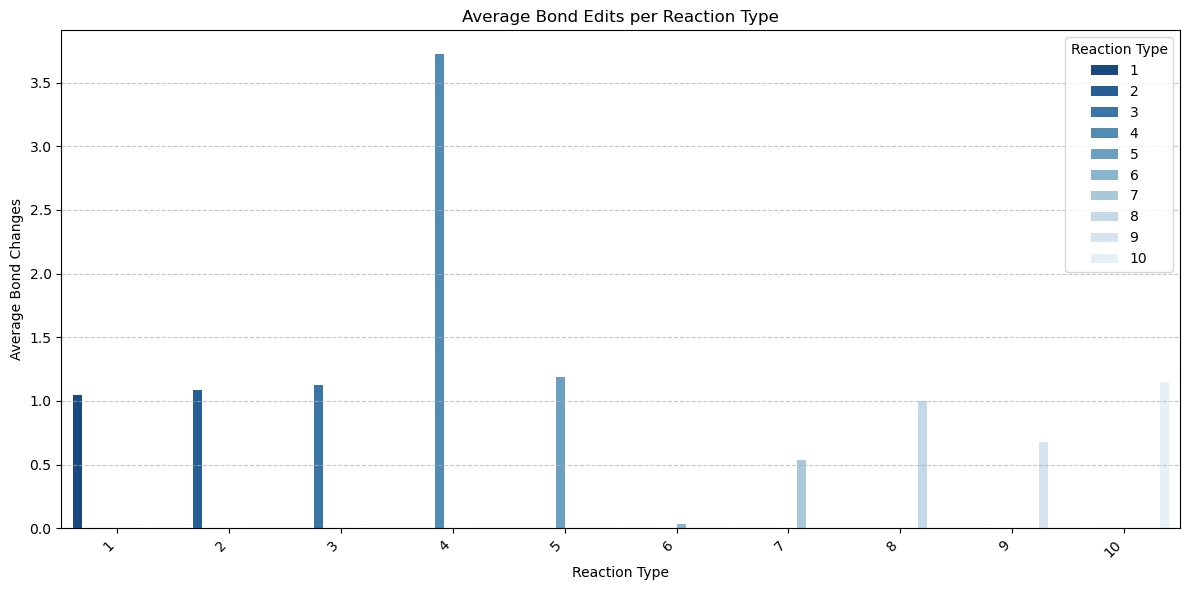

In [24]:
bond_breaking, bond_ordreing = count_bond_changes(whole_data)
print(f"Bond breaking: {bond_breaking}")
print(f"Bond ordering: {bond_ordreing}")

total_bonds = get_number_of_bonds(whole_data)
print(f"Total bonds: {total_bonds}")

print('Percentage of bond breaking: ', bond_breaking/total_bonds*100)
print('Percentage of bond ordering: ', bond_ordreing/total_bonds*100)
print('Percentange of no change bonds: ', (total_bonds - bond_breaking - bond_ordreing )/total_bonds*100)

bond_change_per_molecule= bond_changes_per_product(whole_data)
total_atoms_changes = sum(bond_change_per_molecule)
print(f"Total bond changes: {total_atoms_changes}")
print(f"Percentage of bond changes: {total_atoms_changes/total_bonds*100:.2f}%")
plot_bond_changes_distribution(whole_data)
plot_bond_changes_vs_reaction_type(whole_data)

In [25]:
all_bond_labels = torch.cat([data.rc_bonds for data in whole_data]).long()
class_counts = Counter(all_bond_labels.tolist())
print('class_counts',class_counts)

num_classes = 3
total_bonds = len(all_bond_labels)
class_freqs = torch.tensor([class_counts.get(i, 0) for i in range(num_classes)])
print(f"Class counts: {class_freqs.tolist()}")

class_weights = total_bonds / (num_classes * class_freqs.float().clamp(min=1))
print(f"Class weights: {class_weights.tolist()}")

final_weight = [round(i, 2) for i in class_weights.tolist()]
print(final_weight)

class_counts Counter({0: 2711490, 2: 73920, 1: 14806})
Class counts: [2711490, 14806, 73920]
Class weights: [0.3442407548427582, 63.0423698425293, 12.627236366271973]
[0.34, 63.04, 12.63]


In [26]:
reactive_bonds_list = [data.rc_bonds.sum().item() for data in whole_data]
total_bonds_list= [data.rc_bonds.numel() for data in whole_data]
reactive_bonds = sum(reactive_bonds_list)
total_bonds = sum(total_bonds_list)
print(f"Total bonds: {total_bonds}")
print(f"Reactive bonds: {reactive_bonds}")
print(f"Non-reactive bonds: {total_bonds - reactive_bonds}")
print(f"Positive ratio: {reactive_bonds / total_bonds:.4f}")

Total bonds: 2800216
Reactive bonds: 162646
Non-reactive bonds: 2637570
Positive ratio: 0.0581
